In [71]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential 
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras.layers import Dense, BatchNormalization, Embedding, LSTM
from keras.metrics import Precision
from keras import utils
from keras import callbacks
from sklearn.model_selection import train_test_split
from google.colab import drive
from absl import logging
logging.set_verbosity(logging.ERROR)  # ignore notification

In [2]:
! gdown --id 1JYBDszasL_IVYbKdDYnCPX46G58fIWZT 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1JYBDszasL_IVYbKdDYnCPX46G58fIWZT
To: /content/data.csv
100% 36.1M/36.1M [00:02<00:00, 12.7MB/s]


# Data processing
Our goal at this stage is to transform the texts and labels in such a way that it is possible to submit data to the input of a recursive neural network: X, y

In [52]:
NUM_WORDS = 10000
MAX_TEXT_LEN = 200

In [53]:
# opening .csv files
df = pd.read_csv('/content/data.csv')

In [54]:
# deleting an extra column
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [55]:
def label_processing(labels: pd.Series) -> pd.Series:
    """The function of translation labels to a scale of 0 and 1"""
    processed_labels = labels.apply(func=(lambda value: 1 if value > 5 else 0))
    return processed_labels

def pickle_save(file_name: str, data: Tokenizer) -> None:
    """Data(tokens) saving function in pickle"""
    with open(file_name, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
texts = df['text']
labels = df['label'] 
labels.rename('y', inplace=True)
y = label_processing(labels)  # processed labels: y

In [57]:
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(texts)  # training tokenizer 

In [68]:
tokenizer.word_index  # looking through the tokenizer dictionary

{'the': 1,
 'and': 2,
 'a': 3,
 'to': 4,
 'of': 5,
 'is': 6,
 'it': 7,
 'in': 8,
 'i': 9,
 'this': 10,
 'that': 11,
 'movie': 12,
 'was': 13,
 'but': 14,
 'with': 15,
 'for': 16,
 'as': 17,
 'film': 18,
 'not': 19,
 'you': 20,
 'on': 21,
 'are': 22,
 'be': 23,
 'have': 24,
 'all': 25,
 'like': 26,
 "it's": 27,
 'so': 28,
 'one': 29,
 'good': 30,
 'his': 31,
 'an': 32,
 'from': 33,
 'they': 34,
 'just': 35,
 'story': 36,
 'at': 37,
 'he': 38,
 'by': 39,
 'her': 40,
 'or': 41,
 'some': 42,
 'there': 43,
 'about': 44,
 'has': 45,
 'if': 46,
 'what': 47,
 'more': 48,
 'very': 49,
 'who': 50,
 'out': 51,
 'really': 52,
 'well': 53,
 'time': 54,
 'watch': 55,
 'no': 56,
 'she': 57,
 'up': 58,
 'me': 59,
 'even': 60,
 'their': 61,
 'we': 62,
 'also': 63,
 'which': 64,
 'when': 65,
 'my': 66,
 'will': 67,
 'much': 68,
 'great': 69,
 'can': 70,
 'would': 71,
 'were': 72,
 'how': 73,
 'its': 74,
 'acting': 75,
 'had': 76,
 'characters': 77,
 'too': 78,
 'see': 79,
 "don't": 80,
 'than': 81,
 'mo

In [50]:
pickle_save('tokenizer.pickle', tokenizer)  # saving  the tokens in a json file for further analysis

In [46]:
sequences = tokenizer.texts_to_sequences(texts)

In [47]:
# As a result, the text under the following index was converted to a vector
index = 0 
print(texts[index])
print(sequences[index])

A Canadian bankrobber in the eighties managed to rob dozens of banks. How did he do it? And did he get away with it?The good: this is simply a well made heist movie. Nothing out of the ordinary though, but what makes this movie still worth a watch are the good acting performances. Mel Gibson only has got a small supporting role by the way, so dont expect to see him much than 15 minutes, but in those 15 minutes he does act well being a rough and cunning old crime boss.But the 2 leading actors are a joy to watch as well, with good actor's chemistry. I was really suprised (and pleased) to see these 2 actors, whom I only knew vaguely, perform so naturally. I always like to see a bankrobber play it cool when he robs a bank and this character is not only cool, but also quite funny, in a understated way!This is simply a (slowburning) fun watch of a heist movie. Not laugh out loud funny. Nor is it spectacular. But nonetheless entertaining enough to award it with a decent 7 stars.
[3, 3630, 8, 

In [48]:
X = pad_sequences(sequences, maxlen=MAX_TEXT_LEN)  # Standardization of the number of elements in a vector

# Separation of data into training and test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(f'Training sample size: {len(X_train)}')
print(f'Test sample size: {len(X_test)}')

Training sample size: 37276
Test sample size: 9320


# Creating and training a recurrent model (LSTM)

In [16]:
model = Sequential()
model.add(Embedding(NUM_WORDS, 64, input_length=MAX_TEXT_LEN))
model.add(LSTM(3, return_sequences=True))
model.add(LSTM(5, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(12))
model.add(Dense(1, activation='sigmoid'))

In [17]:
callbacks = [
    callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=10, verbose=1),  
    callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=4, verbose=1, mode='auto')
]

In [18]:
model.compile(metrics=[Precision()], loss='binary_crossentropy', optimizer='rmsprop')

In [19]:
history = model.fit(X_train, y_train, batch_size=150, epochs=15, validation_split=0.2,  callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 16s 34ms/step - loss: 0.4323 - precision: 0.8164 - val_loss: 0.8657 - val_precision: 1.0000 - lr: 0.0010
Epoch 2/15
199/199 [==============================] - 6s 28ms/step - loss: 0.3072 - precision: 0.8900 - val_loss: 0.9044 - val_precision: 0.9970 - lr: 0.0010
Epoch 3/15
199/199 [==============================] - 6s 29ms/step - loss: 0.2644 - precision: 0.9147 - val_loss: 0.5230 - val_precision: 0.7276 - lr: 0.0010
Epoch 4/15
199/199 [==============================] - 6s 28ms/step - loss: 0.2347 - precision: 0.9241 - val_loss: 0.4171 - val_precision: 0.8057 - lr: 0.0010
Epoch 5/15
199/199 [==============================] - 6s 28ms/step - loss: 0.2085 - precision: 0.9347 - val_loss: 0.3556 - val_precision: 0.8592 - lr: 0.0010
Epoch 6/15
199/199 [==============================] - 6s 28ms/step - loss: 0.1854 - precision: 0.9424 - val_loss: 0.5148 - val_precision: 0.9380 - lr: 0.0010
Epoch 7/15
199/199 [==============================]

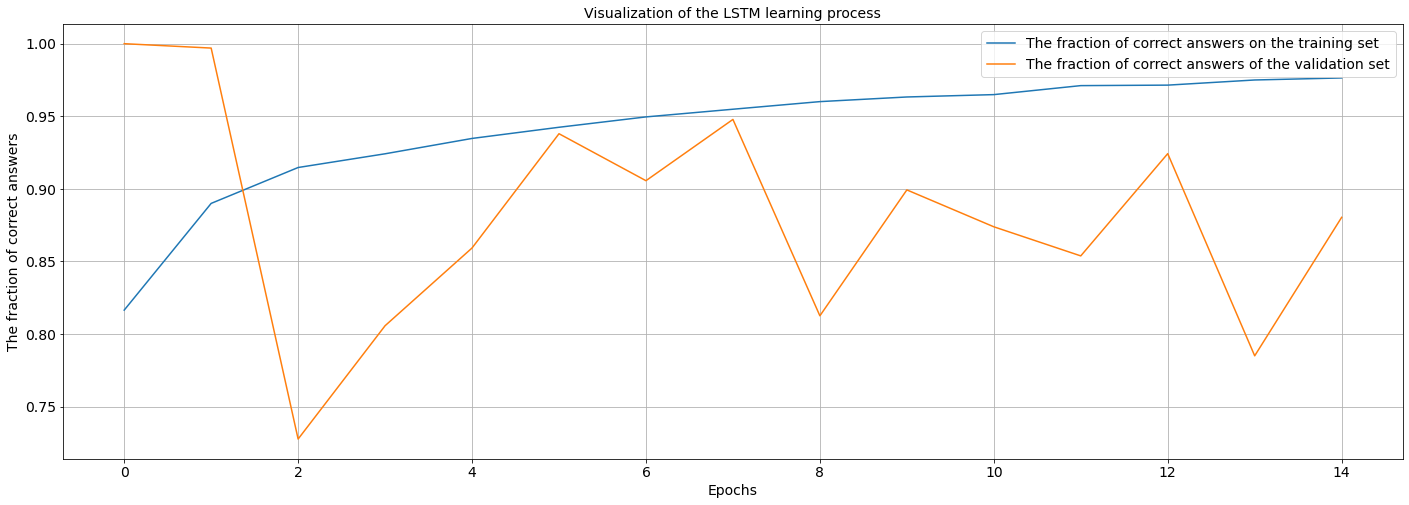

In [31]:
plt.figure(figsize=(24, 8))
plt.title('Visualization of the LSTM learning process', fontsize=14)
plt.plot(history.history['precision'], label='The fraction of correct answers on the training set') 
plt.plot(history.history['val_precision'], label='The fraction of correct answers of the validation set')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('The fraction of correct answers', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.show()

In [21]:
print(f'Metric on test: {model.evaluate(X_test, y_test)}')
print(f'Metric on train: {model.evaluate(X_train, y_train)}')

292/292 [==============================] - 3s 11ms/step - loss: 0.5364 - precision: 0.8820
Metric on test: [0.536375880241394, 0.8819583058357239]
1165/1165 [==============================] - 13s 11ms/step - loss: 0.1644 - precision: 0.9646
Metric on train: [0.16438956558704376, 0.9646444320678711]


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 200, 3)            816       
                                                                 
 lstm_1 (LSTM)               (None, 200, 5)            180       
                                                                 
 batch_normalization (BatchN  (None, 200, 5)           20        
 ormalization)                                                   
                                                                 
 lstm_2 (LSTM)               (None, 12)                864       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                        

In [33]:
model.save('/content/sample_data/lstm_model')  # saving the lstm model for further analysis